# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

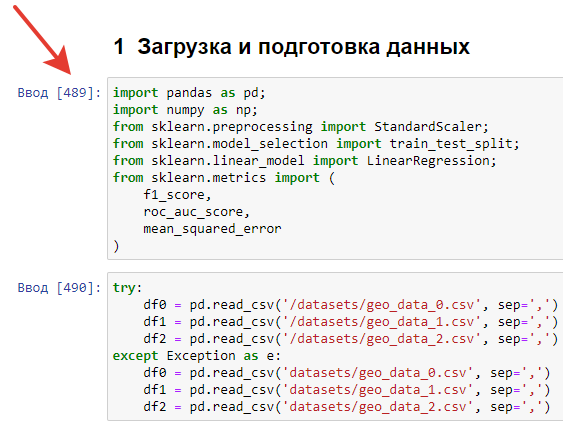

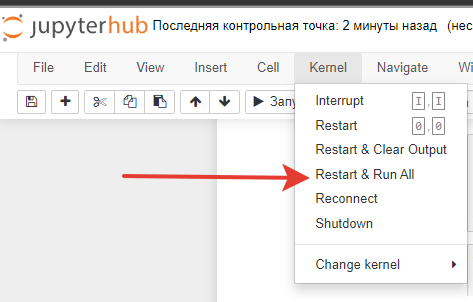

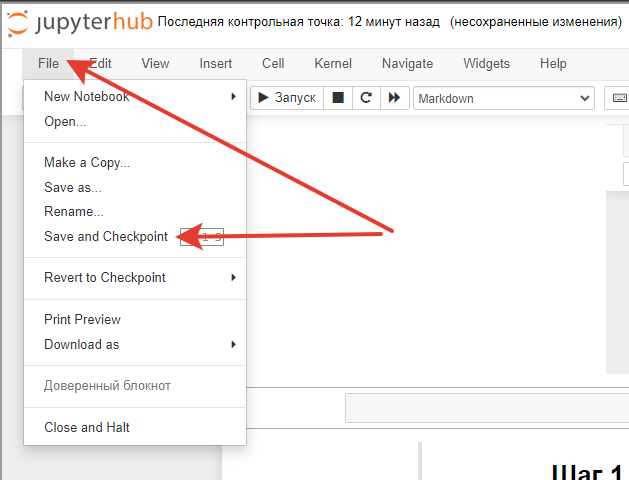

In [1]:
import pandas as pd;
import numpy as np;
import statistics;
from sklearn.preprocessing import StandardScaler;
from sklearn.model_selection import train_test_split;
from sklearn.linear_model import LinearRegression;
from sklearn.metrics import (
    f1_score, 
    roc_auc_score,
    mean_squared_error
)

In [2]:
# Константы
BUDGET = 10e9;
BARREL_PRICE = 450000;
POINTS = 200;
BUDGET_PER_POINT = BUDGET / POINTS;
QUANTILE_LOWER = 0.025;
QUANTILE_UPPER = 0.975;

In [3]:
# Загрузка данных
try:
    df0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',')
    df1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',')
    df2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',')
except Exception as e:
    df0 = pd.read_csv('datasets/geo_data_0.csv', sep=',')
    df1 = pd.read_csv('datasets/geo_data_1.csv', sep=',')
    df2 = pd.read_csv('datasets/geo_data_2.csv', sep=',')

##### Первая выборка:

In [4]:
print(df0.info())
display(df0.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


##### Вторая выборка:

In [5]:
print(df1.info())
display(df1.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


##### Третья выборка:

In [6]:
print(df2.info())
display(df2.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


##### id для обучения не нужен.

In [7]:
df0 = df0.drop('id', axis=1)
df1 = df1.drop('id', axis=1)
df2 = df2.drop('id', axis=1)

## Обучение и проверка модели

In [8]:
# обозначаем числительные данные для маштабирования.
numeric = ['f0', 'f1', 'f2']

##### Обучение и проверка df0

In [9]:
# Определяем целевой признак, делим выборки и проводим маштабирование.
df0_features = df0.drop('product', axis=1)
df0_target = df0['product']

In [10]:
model0_features_train, model0_features_valid, model0_target_train, model0_target_valid = train_test_split(
    df0_features,
    df0_target,
    train_size=0.75,
    test_size=0.25)

In [11]:
# Тренировочная выборка.
scaler0 = StandardScaler()
scaler0.fit(model0_features_train[numeric]) 
model0_features_train[numeric] = scaler0.transform(model0_features_train[numeric])
model0_features_valid[numeric] = scaler0.transform(model0_features_valid[numeric])

In [12]:
# Обучение.
model_0 = LinearRegression(n_jobs=10).fit(model0_features_train, model0_target_train)

prediction_0 = model_0.predict(model0_features_valid)
rmse_0 = mean_squared_error(model0_target_valid, prediction_0, squared=False)
result_0 = model_0.score(model0_features_valid, model0_target_valid)

print("Средний запас предсказанного сырья:", prediction_0.mean())
print("RMSE:", rmse_0)
print("Качество модели:", result_0)

Средний запас предсказанного сырья: 92.5259272465763
RMSE: 37.51811983891303
Качество модели: 0.2798615255951431


##### Обучение и проверка df1

In [13]:
# Определяем целевой признак, делим выборки и проводим маштабирование.
df1_features = df1.drop('product', axis=1)
df1_target = df1['product']

In [14]:
model1_features_train, model1_features_valid, model1_target_train, model1_target_valid = train_test_split(
    df1_features,
    df1_target,
    train_size=0.75,
    test_size=0.25)

In [15]:
# Тренировочная выборка.
scaler1 = StandardScaler()
scaler1.fit(model1_features_train[numeric]) 
model1_features_train[numeric] = scaler1.transform(model1_features_train[numeric])
model1_features_valid[numeric] = scaler1.transform(model1_features_valid[numeric])

In [16]:
# Обучение.
model_1 = LinearRegression().fit(model1_features_train, model1_target_train)

prediction_1 = model_1.predict(model1_features_valid)
rmse_1 = mean_squared_error(model1_target_valid, prediction_1, squared=False)
result_1 = model_1.score(model1_features_valid, model1_target_valid)

print("Средний запас предсказанного сырья:", prediction_1.mean())
print("RMSE:", rmse_1)
print("Качество модели:", result_1)

Средний запас предсказанного сырья: 68.97759558506957
RMSE: 0.8881275454439431
Качество модели: 0.9996257644727331


##### Обучение и проверка df2

In [17]:
# Определяем целевой признак, делим выборки и проводим маштабирование.
df2_features = df2.drop('product', axis=1)
df2_target = df2['product']

In [18]:
model2_features_train, model2_features_valid, model2_target_train, model2_target_valid = train_test_split(
    df2_features,
    df2_target,
    train_size=0.75,
    test_size=0.25)

In [19]:
# Тренировочная выборка.
scaler2 = StandardScaler()
scaler2.fit(model2_features_train[numeric]) 
model2_features_train[numeric] = scaler2.transform(model2_features_train[numeric])
model2_features_valid[numeric] = scaler2.transform(model2_features_valid[numeric])

In [20]:
# Обучение.
model_2 = LinearRegression().fit(model2_features_train, model2_target_train)

prediction_2 = model_2.predict(model2_features_valid)
rmse_2 = mean_squared_error(model2_target_valid, prediction_2, squared=False)
result_2 = model_2.score(model2_features_valid, model2_target_valid)

print("Средний запас предсказанного сырья:", prediction_2.mean())
print("RMSE:", rmse_2)
print("Качество модели:", result_2)

Средний запас предсказанного сырья: 94.88575535499979
RMSE: 40.24149985450621
Качество модели: 0.1958616376205563


##### Вывод:
Более перспективным выглядит регион 1 из-за более низкого RMSE- ~ 0.88 со cредним запасом предсказанного сырья около 68.6. Также самое высокое (подозрительно высокое) качество модели (~ 0.99). Но нужно еще оценить риски.

## Подготовка к расчёту прибыли

In [21]:
print("Бюджет для скважины:", BUDGET_PER_POINT)
print("Безубыточный объём:", BUDGET_PER_POINT / BARREL_PRICE)

Бюджет для скважины: 50000000.0
Безубыточный объём: 111.11111111111111


In [22]:
prediction_0_top200 = sorted(prediction_0, reverse=True)[:POINTS]
print("Средний оборот для региона 0:", statistics.mean(prediction_0_top200) * BARREL_PRICE)

Средний оборот для региона 0: 69751997.0357932


In [23]:
prediction_1_top200 = sorted(prediction_1, reverse=True)[:POINTS]
print("Средний оборот для региона 1:", statistics.mean(prediction_1_top200)* BARREL_PRICE)

Средний оборот для региона 1: 62427016.63696185


In [24]:
prediction_2_top200 = sorted(prediction_2, reverse=True)[:POINTS]
print("Средний оборот для региона 2:", statistics.mean(prediction_2_top200)* BARREL_PRICE)

Средний оборот для региона 2: 66686961.85428114


##### Вывод:
Все три региона покрывают расходы. Но нужно учитывать качество предсказаний и риски.

## Расчёт прибыли и рисков 

In [25]:
# Функция для расчёта прибыли
def revenue(target, predict, barrel_price, budget, points):
    predict_sorted = predict.sort_values(ascending=False)
    target_sorted = target.loc[predict_sorted.index][:points]

    product = target_sorted.sum()
    return product * barrel_price - budget   

##### Сравниваем данные предсказаний с фактическими данными:

In [26]:
# d0
model0_target_valid_revenue = model0_target_valid.reset_index(drop=True)
prediction0_revenue = pd.Series(prediction_0)
print('Возможная прибыль для региона 0:', revenue(model0_target_valid_revenue,
                                        prediction0_revenue,
                                        BARREL_PRICE,
                                        BUDGET,
                                        POINTS))
# d1
model1_target_valid_revenue = model1_target_valid.reset_index(drop=True)
prediction1_revenue = pd.Series(prediction_1)
print('Возможная прибыль для региона 1:', revenue(model1_target_valid_revenue,
                                        prediction1_revenue,
                                        BARREL_PRICE,
                                        BUDGET,
                                        POINTS))
# d2
model2_target_valid_revenue = model2_target_valid.reset_index(drop=True)
prediction2_revenue = pd.Series(prediction_2)
print('Возможная прибыль для региона 2:', revenue(model2_target_valid_revenue,
                                        prediction2_revenue,
                                        BARREL_PRICE,
                                        BUDGET,
                                        POINTS))

Возможная прибыль для региона 0: 3185072549.979933
Возможная прибыль для региона 1: 2415086696.681511
Возможная прибыль для региона 2: 2629688666.6403255


##### Находим распределение прибыли с помощью bootstrap, среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [28]:
def bootstrap(target, predict, barrel_price, budget, points):
    state = np.random.RandomState(2503)
    values = []
    
    target = target.reset_index(drop=True)
    predict = pd.Series(predict)
    for i in range(1000):
        target_500 = target.sample(500, replace=True, random_state=state)
        predict_500 = predict.loc[target_500.index]
        values.append(revenue(target_500, predict_500, BARREL_PRICE, BUDGET, POINTS)) 

    return pd.Series(values) 

##### Проверяем d0

In [29]:
values_0 = bootstrap(model0_target_valid, prediction_0, BARREL_PRICE, BUDGET, POINTS)

print("Средняя прибыль для региона 0:", values_0.mean())
print("Нижний квантиль для региона 0:", values_0.quantile(QUANTILE_LOWER))
print("Верхний квантиль для региона 0:666", values_0.quantile(QUANTILE_UPPER))
print('Риск убытков = {:.2%} '.format((values_0<0).mean()))

Средняя прибыль для региона 0: 472580471.0789854
Нижний квантиль для региона 0: -76016145.06842878
Верхний квантиль для региона 0:666 1001975918.476762
Риск убытков = 4.70% 


##### Проверяем d01

In [30]:
values_1 = bootstrap(model1_target_valid, prediction_1, BARREL_PRICE, BUDGET, POINTS)

print("Средняя прибыль для региона 1:", values_1.mean())
print("Нижний квантиль для региона 1:", values_1.quantile(QUANTILE_LOWER))
print("Верхний квантиль для региона 1:", values_1.quantile(QUANTILE_UPPER))
print('Риск убытков = {:.2%} '.format((values_1<0).mean()))

Средняя прибыль для региона 1: 530580720.8457832
Нижний квантиль для региона 1: 108841283.15667534
Верхний квантиль для региона 1: 974406386.288856
Риск убытков = 0.70% 


##### Проверяем d2

In [31]:
values_2 = bootstrap(model2_target_valid, prediction_2, BARREL_PRICE, BUDGET, POINTS)

print("Средняя прибыль для региона 2:", values_2.mean())
print("Нижний квантиль для региона 2:", values_2.quantile(QUANTILE_LOWER))
print("Верхний квантиль для региона 2:", values_2.quantile(QUANTILE_UPPER))
print('Риск убытков = {:.2%} '.format((values_2<0).mean()))

Средняя прибыль для региона 2: 408311770.96466535
Нижний квантиль для региона 2: -132801958.99115337
Верхний квантиль для региона 2: 931324849.2919263
Риск убытков = 8.10% 


##### Вывод:
Наиболее подходящий регион - регион 1. Риск убытков около 1%. Мы также наблюдаем положительные значения в нижем и верхнем квантилях и более высокая средняя прибыль. Качество модели обучения выше, что может сделать анализ скважин более предсказуемым.

Остальные регионы показывают отрицательный квантиль, убыточны, высокая средняя квадратичная ошибка, качество модели низкое да и вообще не очень-то и хотелось их разрабытывать (наверное, судя по данным).

Ввиду чего, для дальнейшего анализа подходит регион 1.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован